In [131]:
import random
from collections import namedtuple
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm import trange

In [132]:
np.random.seed(42)
random.seed(42)

In [133]:
ACTION_TAKE_MORE = 'hit'
ACTION_STOP_TAKING = 'stick'
hit_action = 'hit'
stick_action = 'stick'
discont = 1

def draw_card(summ_score):
    result = summ_score

    probability = random.randint(1, 3)

    card_value = random.randint(1, 10)

    if probability > 1:
        result += card_value
    else:
        result -= card_value

    return result

def environment_step(s, a):
    (shuffler_open_card_value, summ_score) = s

    if a == stick_action:
        shuffler_score = shuffler_open_card_value

        while shuffler_score < 12:
            shuffler_score += draw_card(shuffler_open_card_value)

            if shuffler_score > 21 or shuffler_score < 0:
                return None, 1

        if shuffler_score > summ_score:
            return None, -1
        elif shuffler_score == summ_score:
            return None, 0
        else:
            return None, 1


    if a == hit_action:
        player_summ_score = summ_score

        player_summ_score += draw_card(player_summ_score)

        if player_summ_score > 21 or player_summ_score < 0:
            return None, -1

        return (shuffler_open_card_value, player_summ_score), 0


def is_terminal(s):
    return s is None

s1, r = environment_step((1, 18), ACTION_TAKE_MORE)
s1, r, is_terminal(s1)

(None, -1, True)

In [134]:
def get_start_state():
    taker_card, player_card = random.randint(1, 10), random.randint(1, 10)
    return taker_card, player_card

def glie_mc_estimate(episodes, n0, gamma=1):
    policy = np.zeros((11, 22), dtype=int)
    q = np.zeros((11, 22, 2))
    n = np.zeros((11, 22, 2))

    action_number_to_str = {
        0: ACTION_TAKE_MORE,
        1: ACTION_STOP_TAKING
    }

    for _ in trange(episodes):
        episode = list()
        episode_without_rewards = list()

        s = get_start_state()

        while not is_terminal(s):
            e = n0 / (n0 + np.sum(n[s]))
            if np.random.random(1)[0] <= e:
                a = np.random.choice([0, 1], 1)[0]
            else:
                a = policy[s]
            s1, r = environment_step(
                s,
                action_number_to_str[a]
            )
            episode.append((s, a, r))
            episode_without_rewards.append((s, a))
            s = s1
        # print(episode)
        g = 0
        for i in range(len(episode) - 1, -1, -1):
            s, a, r = episode[i]
            g = gamma * g + r

            if episode_without_rewards.index((s, a)) != i:
                continue

            q_index = s[0], s[1], a
            n[q_index] += 1
            q[q_index] += 1 / n[q_index] * (g - q[q_index])
            a_star = np.argmax(q[s])
            # e = n0 / (n0 + np.sum(n[s]))

            # for action in (0, 1):
            #     policy[s[0], s[1], action] = \
            #         1 - e + e / 2 if action == a_star else e / 2
            # policy[s] /= policy[s].sum()
            policy[s] = a_star

    return policy, q

p, q = glie_mc_estimate(100000, 100);

100%|██████████| 100000/100000 [00:02<00:00, 49253.21it/s]


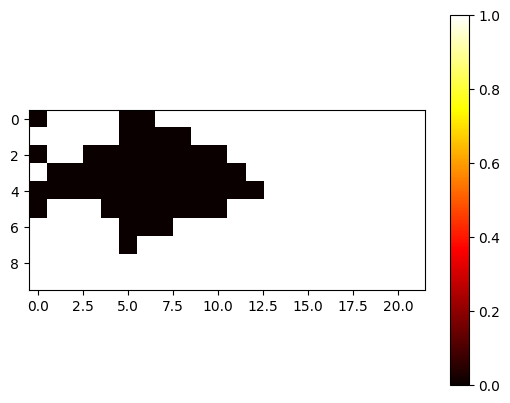

In [135]:
plt.imshow(p[1:,:], cmap='hot')
plt.colorbar();

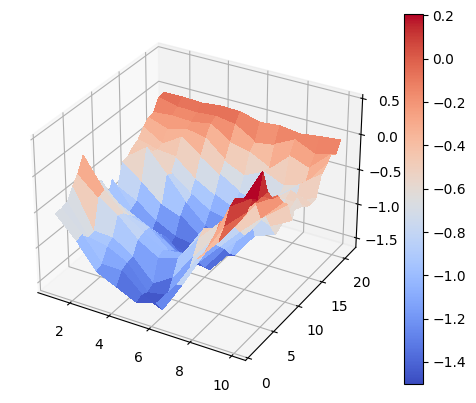

In [136]:
X = np.arange(1, 11, 1)
Y = np.arange(1, 22, 1)
X, Y = np.meshgrid(X, Y)
Z = np.sum(q, axis=2)[X, Y]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf);